In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [209]:
def preprocess_image(img,skip_dilate=False):
    img = cv2.GaussianBlur(img.copy(), (15, 15), 0)
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    img = cv2.bitwise_not(img, img)
    if not skip_dilate:
        kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]],np.uint8)
        img = cv2.dilate(img, kernel, iterations=1)
    return img

In [13]:
def show_external_contours(img):
    ext_contours, hier = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    # Draw all of the contours on the image in 2px red lines
    external_contours = cv2.drawContours(img.copy(), ext_contours, -1, (255, 0, 0), 2)
    plt.imshow(external_contours)
    plt.show()

In [4]:
import operator

def find_corners_of_largest_polygon(img):
    #Finds the 4 extreme corners of the largest contour in the image.
    contours, h = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # Find external contours
    contours = sorted(contours, key=cv2.contourArea, reverse=True)  # Sort by area, descending
    polygon = contours[0]  # Largest image
    # Use of `operator.itemgetter` with `max` and `min` allows us to get the index of the point
    # Each point is an array of 1 coordinate, hence the [0] getter, then [0] or [1] used to get x and y respectively.

    # Bottom-right point has the largest (x + y) value
    # Top-left has point smallest (x + y) value
    # Bottom-left point has smallest (x - y) value
    # Top-right point has largest (x - y) value
    bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))

    # Return an array of all 4 points using the indices
    # Each point is in its own array of one coordinate
    return [polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]]

In [5]:
def display_points(in_img, points, radius=5, colour=(0, 0, 255)):
    """Draws circular points on an image."""
    img = in_img.copy()

    # Dynamically change to a colour image if necessary
    if len(colour) == 3:
        if len(img.shape) == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        elif img.shape[2] == 1:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    for point in points:
        img = cv2.circle(img, tuple(int(x) for x in point), radius, colour, -1)
    return img

In [8]:
def plt_show(img,cmap='gray'):
    plt.imshow(img,cmap=cmap)
    plt.xticks([])
    plt.yticks([])
    plt.show()

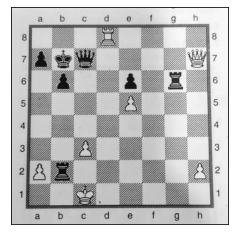

In [9]:
original_image = cv2.resize(cv2.imread('TestBoard1.jpeg',0),(512,512))
plt_show(original_image)

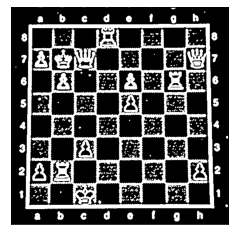

In [11]:
preprocessed_image = preprocess_image(original_image)
plt_show(preprocessed_image)

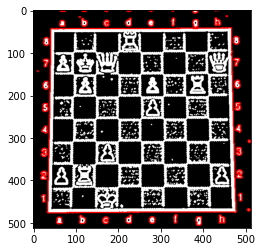

In [16]:
show_external_contours(preprocessed_image)

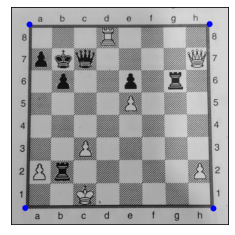

In [19]:
points = find_corners_of_largest_polygon(preprocessed_image)
corner_point_img = display_points(original_image,points,radius=7)
plt_show(corner_point_img)

In [21]:
def distance_between(p1, p2):
    a = p2[0] - p1[0]
    b = p2[1] - p1[1]
    return np.sqrt((a ** 2) + (b ** 2))

def crop_and_warp(img, points):
    # Rectangle described by top left, top right, bottom right and bottom left points
    top_left, top_right, bottom_right, bottom_left = points[0], points[1], points[2], points[3]

    # Explicitly set the data type to float32 or `getPerspectiveTransform` will throw an error
    src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')

    # Get the longest side in the rectangle
    side = max([
        distance_between(bottom_right, top_right),
        distance_between(top_left, bottom_left),
        distance_between(bottom_right, bottom_left),
        distance_between(top_left, top_right)
    ])
    # Describe a square with side of the calculated length, this is the new perspective we want to warp to
    dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')

    # Gets the transformation matrix for skewing the image to fit a square by comparing the 4 before and after points
    m = cv2.getPerspectiveTransform(src, dst)

    # Performs the transformation on the original image
    return cv2.warpPerspective(img, m, (int(side), int(side)))

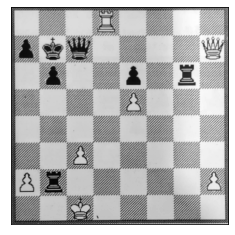

In [22]:
cropped_image = crop_and_warp(original_image,points)
plt_show(cropped_image)

In [28]:
def get_chessboard(filename):
    original_image = cv2.resize(cv2.imread(filename,0),(512,512))
    preprocessed_image = preprocess_image(original_image)
    points = find_corners_of_largest_polygon(preprocessed_image)
    cropped_image = crop_and_warp(original_image,points)
    fig = plt.figure(figsize=(10, 7))
    fig.add_subplot(1, 2, 1)
    plt.imshow(original_image,cmap='gray')
    plt.xticks([])
    plt.yticks([])
#     plt.axis('off')
    plt.title("Original Image")

    fig.add_subplot(1, 2, 2)
    plt.imshow(cropped_image,cmap='gray')
    plt.xticks([])
    plt.yticks([])
#     plt.axis('off')
    plt.title("Extracted ChessBoard")
    plt.show()
    return cropped_image
    

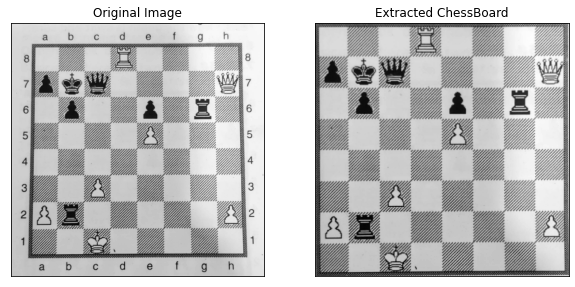

In [29]:
chessboard = get_chessboard('TestBoard1.jpeg')

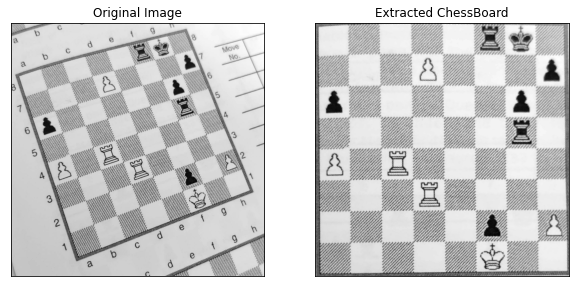

In [30]:
chessboard1 = get_chessboard('TestBoard2.jpeg')

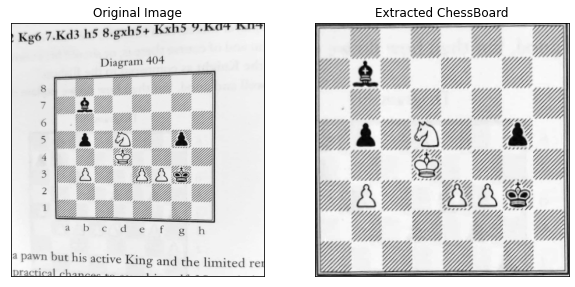

In [31]:
chessboard3 = get_chessboard('TestBoard3.jpeg')

In [32]:
def split_cells(img):
    squares = []
    side = img.shape[:1][0]/8
    for i in range(8):
        for j in range(8):
            p1 = (i * side, j * side)  # Top left corner of a bounding box
            p2 = ((i + 1) * side, (j + 1) * side)  # Bottom right corner of bounding box
            squares.append((p1, p2))
    return squares

In [33]:
def display_rects(in_img, rects, colour=255):
    """Displays rectangles on the image."""
    img = in_img.copy()
    for rect in rects:
        img = cv2.rectangle(img, tuple(int(x) for x in rect[0]), tuple(int(x) for x in rect[1]), colour)
    plt_show(img)

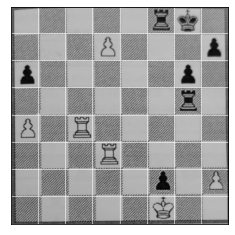

In [60]:
display_rects(chessboard1,split_cells(chessboard1))

In [55]:
cells = split_cells(chessboard)
print(len(cells))

64


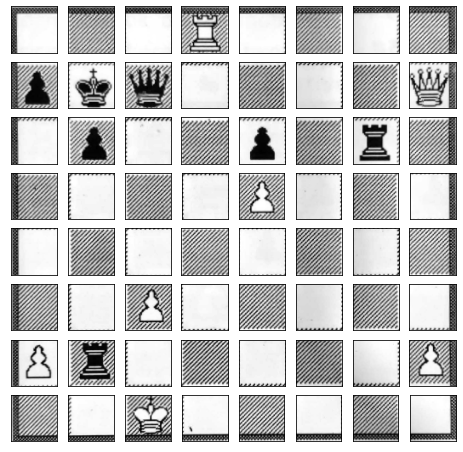

In [98]:
fig = plt.figure(figsize=(8, 8))
columns = 8
rows = 8
cells = split_cells(chessboard)
for i in range(64):
    cell = cells[i]
    (r1,c1),(r2,c2) = cell
    r1 = int(r1)
    r2 = int(r2)
    c1 = int(c1)
    c2 = int(c2)
    fig.add_subplot(rows, columns, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(chessboard[r1:r2,c1:c2],cmap='gray')
plt.show()

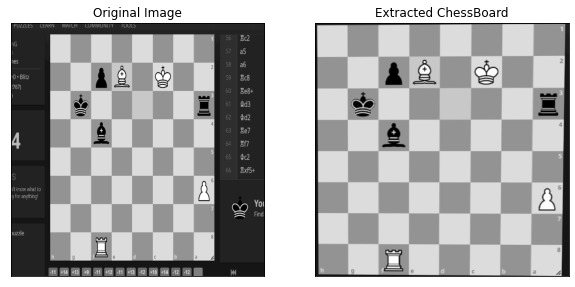

In [99]:
chessboard4 = get_chessboard('TestBoard4.png')

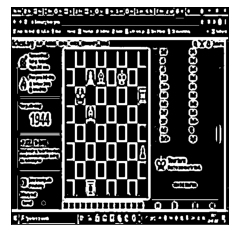

In [93]:
lichess_board = cv2.resize(cv2.imread('TestBoard4.png',0),(512,512))
processed_lichess = trial_image(lichess_board)
plt_show(processed_lichess)

In [92]:
def trial_image(img):
    img = cv2.GaussianBlur(img.copy(), (9, 9), 0)
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
#     ret, img = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY)
    img = cv2.bitwise_not(img, img)
    kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]],np.uint8)
#     img = cv2.dilate(img, kernel, iterations=1)
    return img

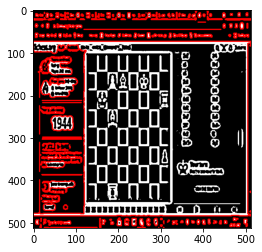

In [94]:
show_external_contours(processed_lichess)

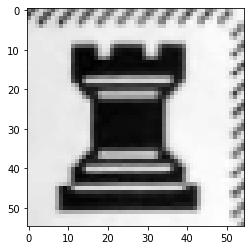

In [258]:
cell = cells[22]
(r1,c1),(r2,c2) = cell
r1 = int(r1)
r2 = int(r2)
c1 = int(c1)
c2 = int(c2)
rookimg = chessboard[r1:r2,c1:c2].copy()
plt.imshow(rookimg,cmap='gray')
plt.show()

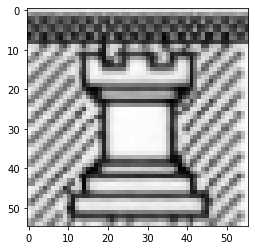

In [262]:
cell = cells[3]
(r1,c1),(r2,c2) = cell
r1 = int(r1)
r2 = int(r2)
c1 = int(c1)
c2 = int(c2)
rook2 = chessboard[r1:r2,c1:c2].copy()
plt.imshow(rook2,cmap='gray')
plt.show()

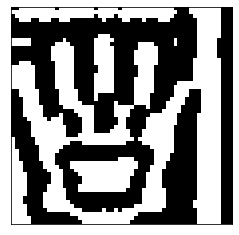

In [171]:
proc = cv2.adaptiveThreshold(proc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
plt_show(proc)

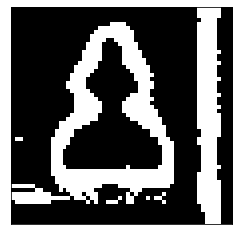

In [214]:
proc = preprocess_image(rookimg,True)
plt_show(proc)

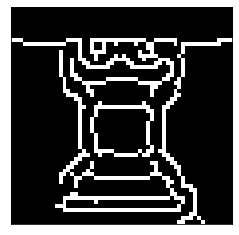

In [238]:
gaussed = cv2.GaussianBlur(rookimg.copy(), (7, 7), 0)
# gaussed = cv2.adaptiveThreshold(gaussed, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
gaussed_neg = cv2.bitwise_not(gaussed.copy(), gaussed.copy())
edges = cv2.Canny(gaussed,0,200)
plt_show(edges)

In [138]:
def backfilter(ima,finalshape=(32,32),passes=2):
    imlarge = cv2.resize(ima,(128,128),interpolation = cv2.INTER_CUBIC)    
    for _ in range(passes):
        mask = np.zeros(imlarge.shape,np.uint8)
        ee = cv2.Canny(imlarge,200,400,apertureSize = 3)
        contours,_ = cv2.findContours(ee, 1, 2)
        dashes = [c for c in contours if abs(cv2.minAreaRect(c)[2]+45)<18]
        cv2.drawContours(mask,dashes,-1,255,4)
        imclean = np.where(mask==0,imlarge,0)
        imlarge = imclean
    return cv2.resize(imclean,finalshape,interpolation=cv2.INTER_AREA)

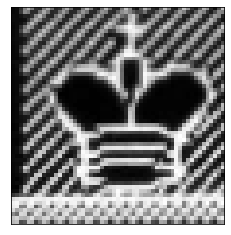

In [203]:
rooknobg = backfilter(rookimg)
ima3 = np.bitwise_not(np.asarray(rookimg))
plt_show(ima3)

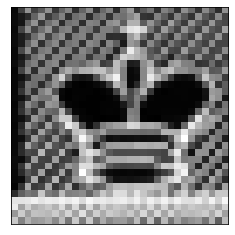

In [204]:
plt_show(backfilter(ima3))

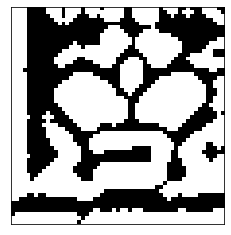

In [205]:
ima3 = preprocess_image(ima3)
plt_show(ima3)

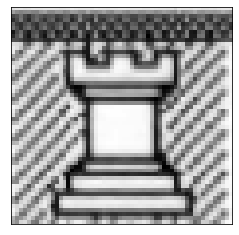

In [239]:
plt_show(rookimg)

In [ ]:
f

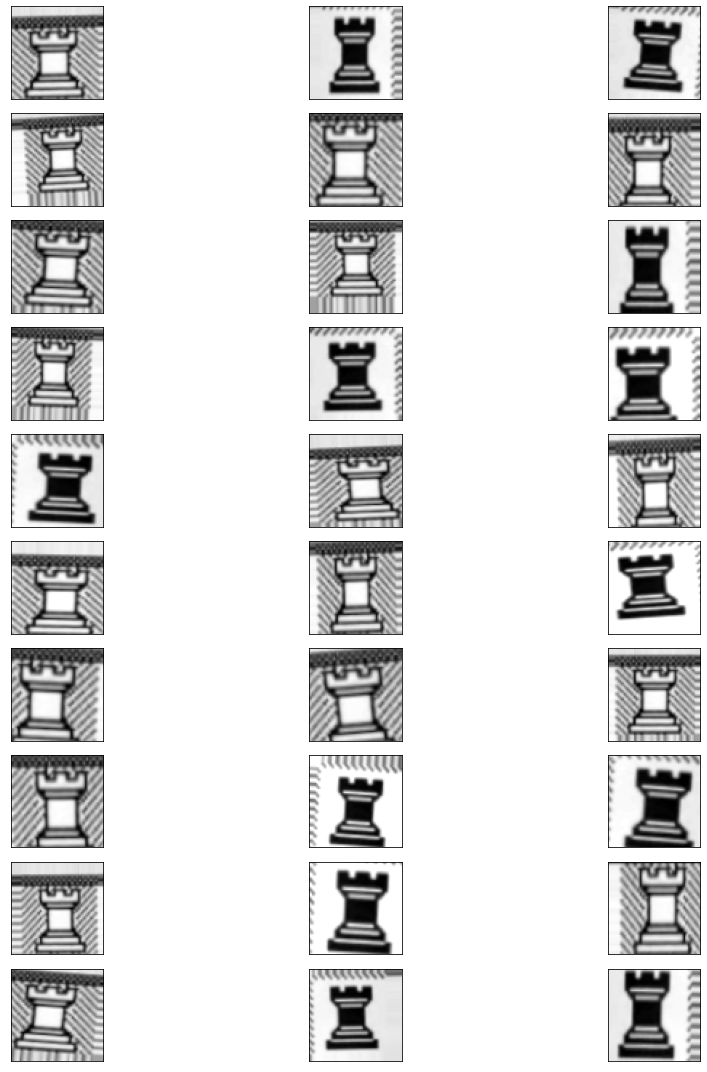

In [267]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import io
datagen = ImageDataGenerator(
        rotation_range=5, # rotation
        width_shift_range=0.1, # horizontal shift
        height_shift_range=0.1, # vertical shift
        zoom_range=0.2, # zoom
        shear_range=0.1,
        horizontal_flip=True, # horizontal flip
        brightness_range=[0.2,1.2]) # brightness
rookimg = cv2.resize(rookimg,(64,64))
rook2 = cv2.resize(rook2,(64,64))
rookimg = rookimg.reshape(64,64,1)
rook2 = rook2.reshape(64,64,1)
# print(rookimg.shape)
aug_iter = datagen.flow(np.array([rookimg,rook2]), batch_size=2)

# generate samples and plot
fig = plt.figure(figsize=(15,15))

for i in range(30):
    image = next(aug_iter)[0].astype('uint8')
    fig.add_subplot(10, 3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image,cmap='gray')
    cv2.imwrite("Rook{}.jpg".format(i+1),image)
fig.tight_layout()
plt.show()